In [2]:
%load_ext autoreload
%autoreload 2
import pyroSAR
from s1pro.auxils import get_burst_geometry
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt

In [21]:
infiles = ['/data/S1/S1A_IW_SLC__1SDV_20230826T180527_20230826T180554_050050_0605B2_E768.zip',
           '/data/S1/S1A_IW_SLC__1SDV_20230814T180526_20230814T180553_049875_05FFB4_7D92.zip']
outdir = '/data/res/'
aoi_path = '/data/aoi_bretagne.geojson'
graph_path = '../graph/TOPSAR Coreg Interferogram IW2 to GeoTiff.xml'

In [22]:
# let's find what iw and bursts intersect AOI
df_geo = get_burst_geometry(infiles[0], 
                   target_subswaths=['IW1', 'IW2','IW3'], 
                   polarization='VV')
aoi = gpd.read_file(aoi_path)

In [23]:
df_sel = df_geo[df_geo.intersects(aoi.geometry[0])]
unique_subswaths = df_sel['subswath'].unique()

In [26]:
from pyroSAR.snap.auxil import Workflow, gpt, groupbyWorkers
wfl = Workflow(graph_path)
wfl['Read'].parameters['file'] = infiles[0]
wfl['Read(2)'].parameters['file'] = infiles[1]
for subswath in unique_subswaths[:1]:
    print(f"Subswath {subswath}, bursts {df_sel[df_sel['subswath']==subswath]['burst'].values}")
    wfl['TOPSAR-Split'].parameters['subswath'] = subswath
    wfl['TOPSAR-Split(2)'].parameters['subswath'] = subswath
    bursts = df_sel[df_sel['subswath']==subswath]['burst'].values
    burst_min = bursts.min()
    burst_max = bursts.max()
    wfl['TOPSAR-Split'].parameters['firstBurstIndex'] = burst_min
    wfl['TOPSAR-Split'].parameters['lastBurstIndex'] = burst_max
    wfl['TOPSAR-Split(2)'].parameters['firstBurstIndex'] = burst_min
    wfl['TOPSAR-Split(2)'].parameters['lastBurstIndex'] = burst_max
    wfl['Write'].parameters['file'] = f"{outdir}/{subswath}_IFG.tif"
    wfl.write('/tmp/graph.xml')
    grp = groupbyWorkers('/tmp/graph.xml', n=1)
    gpt('/tmp/graph.xml', groups=grp, tmpdir='/data/tmp/')

Subswath IW2, bursts [4 5 6]


In [28]:
import rasterio as rio

# with rio.open('/data/tmp/S1_A_relOrb_103_COH__VV_20230826T180527_20230814T180526/S1_A_relOrb_103_COH__VV_20230826T180527_20230814T180526.tif') as ds:
with rio.open(f"{outdir}/{subswath}_IFG.tif") as ds:
# with rio.open('/data/tmp/S1_relOrb_TEST_split_before_orbit.tif') as ds:
    print(ds.profile)
    img = ds.read(3)
    # re = ds.read(1)
    # im = ds.read(2)

# print(wfl)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 26057, 'height': 4192, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8595199965609766e-05, 0.0, 0.0,
       0.0, -0.00012955738782238768, 0.0), 'blockxsize': 528, 'blockysize': 528, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


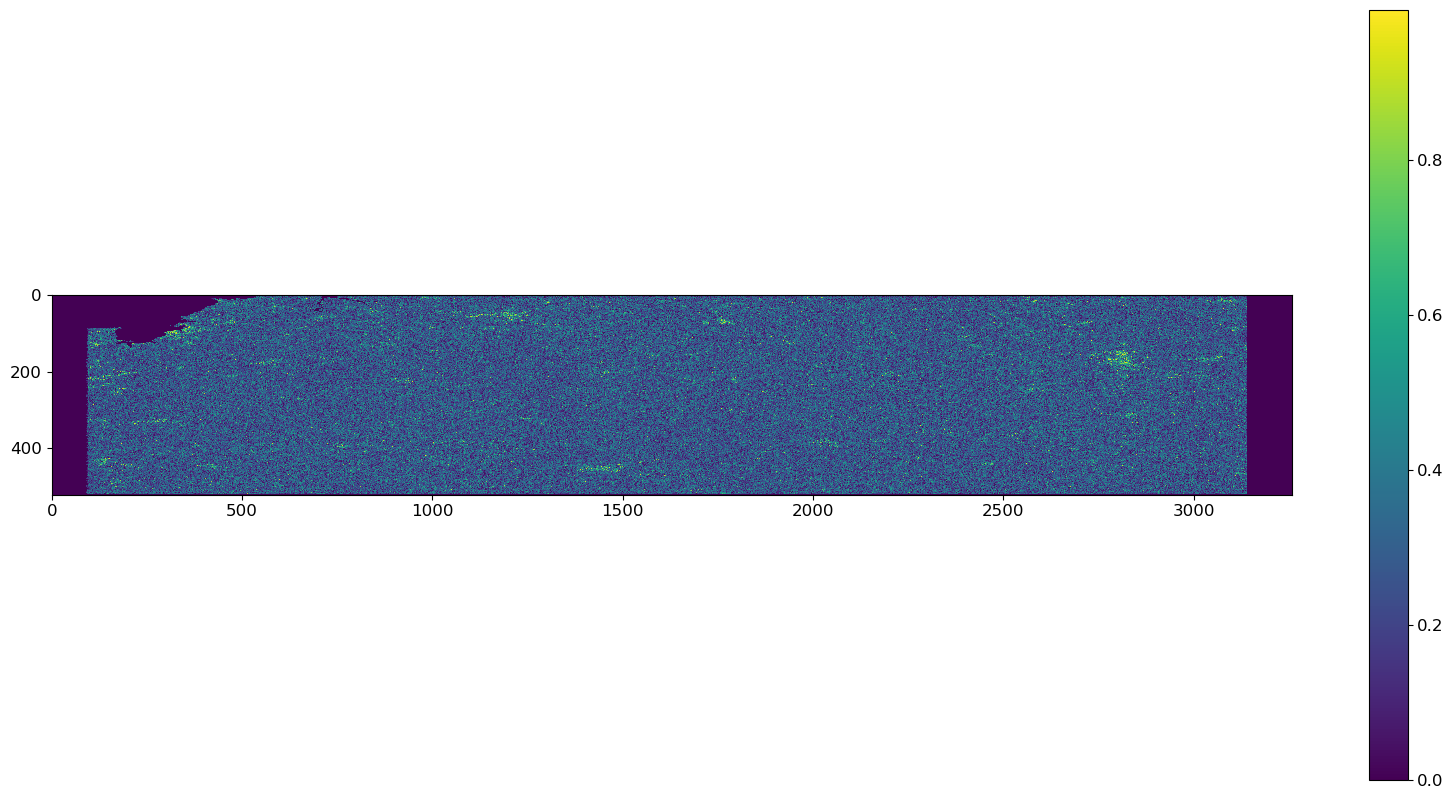

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(img[::8,::8], interpolation='nearest')#, vmin=0, vmax=100000)
plt.colorbar()